In [1]:
# Use islands conda env
import re
import requests
from bs4 import BeautifulSoup
from copy import deepcopy
from time import sleep
from datetime import datetime
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

In [2]:
STATEFP_dict = dict([['31', 'Nebraska'],
       ['53', 'Washington'],
       ['35', 'New Mexico'],
       ['46', 'South Dakota'],
       ['48', 'Texas'],
       ['06', 'California'],
       ['21', 'Kentucky'],
       ['39', 'Ohio'],
       ['01', 'Alabama'],
       ['13', 'Georgia'],
       ['55', 'Wisconsin'],
       ['41', 'Oregon'],
       ['42', 'Pennsylvania'],
       ['28', 'Mississippi'],
       ['29', 'Missouri'],
       ['37', 'North Carolina'],
       ['40', 'Oklahoma'],
       ['54', 'West Virginia'],
       ['36', 'New York'],
       ['18', 'Indiana'],
       ['20', 'Kansas'],
       ['16', 'Idaho'],
       ['32', 'Nevada'],
       ['50', 'Vermont'],
       ['30', 'Montana'],
       ['27', 'Minnesota'],
       ['38', 'North Dakota'],
       ['15', 'Hawaii'],
       ['04', 'Arizona'],
       ['10', 'Delaware'],
       ['44', 'Rhode Island'],
       ['08', 'Colorado'],
       ['49', 'Utah'],
       ['51', 'Virginia'],
       ['56', 'Wyoming'],
       ['22', 'Louisiana'],
       ['26', 'Michigan'],
       ['25', 'Massachusetts'],
       ['12', 'Florida'],
       ['78', 'United States Virgin Islands'],
       ['09', 'Connecticut'],
       ['34', 'New Jersey'],
       ['24', 'Maryland'],
       ['45', 'South Carolina'],
       ['23', 'Maine'],
       ['33', 'New Hampshire'],
       ['11', 'District of Columbia'],
       ['66', 'Guam'],
       ['69', 'Commonwealth of the Northern Mariana Islands'],
       ['60', 'American Samoa'],
       ['19', 'Iowa'],
       ['72', 'Puerto Rico'],
       ['05', 'Arkansas'],
       ['47', 'Tennessee'],
       ['17', 'Illinois'],
       ['02', 'Alaska']])

In [3]:
shape_df = gpd.read_file('data/cb_2018_us_county_5m.shp')
shape_df['State'] = shape_df.apply(lambda x: STATEFP_dict[x['STATEFP']], axis=1)
shape_df = shape_df.drop(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'LSAD', 'ALAND', 'AWATER'], axis=1)
shape_df.columns = ['County', 'geometry', 'State']

In [4]:
def county_df_maker(results):
    table = []
    header = ['County', 'Candidate', 'Margin', '2016 margin', 'Est. votes reported', 'Total votes', 'Absentee']
    result_list = results[1].find_all('tr')
    result_list = result_list[1:-1]
    for rslt in result_list:
        if 'Biden' in rslt.text:
            index = rslt.text.find('Biden')
        elif 'Trump' in rslt.text:
            index = rslt.text.find('Trump')
        county_name = [rslt.text[:index].strip()]
        county_name.extend(rslt.text[index:].split())
        table.append(county_name)
    state_df = pd.DataFrame(table, columns = header)
    state_df = state_df.drop(['2016 margin', 'Absentee', 'Est. votes reported'], axis=1)
    state_df.Margin = state_df.Margin.str[1:].astype('float')
    state_df.Margin = state_df.Margin/100
    state_df['Total votes'] = state_df['Total votes'].str.replace(',', '').astype('int')
    state_df['Biden vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Biden' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
    state_df['Trump vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Trump' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
    state_df['Biden Share'] = state_df['Biden vote approx']/state_df['Total votes']
    state_df['Trump Share'] = state_df['Trump vote approx']/state_df['Total votes']
    return state_df

In [5]:
state_names = ["Alabama", "Arkansas", "Arizona", "California", "Colorado", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Indiana", "Kansas", "Kentucky", "Louisiana", "Maryland", "Michigan", "Minnesota", "Missouri", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
non_county_states = ["Alaska", "Connecticut", "Illinois", "Massachusetts", "Maine", "Mississippi", "New Hampshire", "Rhode Island", "Vermont"]
state_names = [state.lower() for state in state_names]
state_names = [state.replace(' ', '-') for state in state_names]

df_list = []

for state_with_dash in state_names:
    URL = f'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-{state_with_dash}.html?action=click&pgtype=Article&state=default&module=styln-elections-2020&region=TOP_BANNER&context=election_recirc'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    results = soup.find_all('table')
    # print(state_with_dash)
    df_list.append((state_with_dash.replace('-', ' ').title(), county_df_maker(results)))

In [6]:
# ALASKA

state_with_dash = "alaska"
URL = f'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-{state_with_dash}.html?action=click&pgtype=Article&state=default&module=styln-elections-2020&region=TOP_BANNER&context=election_recirc'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find_all('table')
table = []
header = ['County', 'Candidate', 'Margin', 'Est. votes reported', 'Total votes', 'Absentee']
result_list = results[1].find_all('tr')
result_list = result_list[1:-1]
for rslt in result_list:
    if 'Biden' in rslt.text:
        index = rslt.text.find('Biden')
    elif 'Trump' in rslt.text:
        index = rslt.text.find('Trump')
    county_name = [rslt.text[:index].strip()]
    county_name.extend(rslt.text[index:].split())
    table.append(county_name)
state_df = pd.DataFrame(table, columns = header)
state_df = state_df.drop(['Absentee', 'Est. votes reported'], axis=1)
state_df.Margin = state_df.Margin.str[1:].astype('float')
state_df.Margin = state_df.Margin/100
state_df['Total votes'] = state_df['Total votes'].str.replace(',', '').astype('int')
state_df['Biden vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Biden' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Trump vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Trump' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Biden Share'] = state_df['Biden vote approx']/state_df['Total votes']
state_df['Trump Share'] = state_df['Trump vote approx']/state_df['Total votes']
state_df['State'] = state_with_dash.title()
ak_df = state_df

In [7]:
# CONNECTICUT

state_with_dash = "connecticut"
URL = f'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-{state_with_dash}.html?action=click&pgtype=Article&state=default&module=styln-elections-2020&region=TOP_BANNER&context=election_recirc'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find_all('table')
table = []
header = ['County', 'Candidate', 'Margin', 'Est. votes reported', 'Total votes', 'Absentee']
result_list = results[1].find_all('tr')
result_list = result_list[1:-1]
for rslt in result_list:
    if 'Biden' in rslt.text:
        index = rslt.text.find('Biden')
    elif 'Trump' in rslt.text:
        index = rslt.text.find('Trump')
    county_name = [rslt.text[:index].strip()]
    county_name.extend(rslt.text[index:].split())
    table.append(county_name)
state_df = pd.DataFrame(table, columns = header)
state_df = state_df.drop(['Absentee', 'Est. votes reported'], axis=1)
state_df.Margin = state_df.Margin.str[1:].astype('float')
state_df.Margin = state_df.Margin/100
state_df['Total votes'] = state_df['Total votes'].str.replace(',', '').astype('int')
state_df['Biden vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Biden' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Trump vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Trump' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Biden Share'] = state_df['Biden vote approx']/state_df['Total votes']
state_df['Trump Share'] = state_df['Trump vote approx']/state_df['Total votes']
state_df['State'] = state_with_dash.title()
ct_df = state_df

In [8]:
# ILLINOIS

state_with_dash = "illinois"
URL = f'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-{state_with_dash}.html?action=click&pgtype=Article&state=default&module=styln-elections-2020&region=TOP_BANNER&context=election_recirc'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find_all('table')
table = []
header = ['County', 'Candidate', 'Margin', '2016 margin', 'Est. votes reported', 'Total votes', 'Absentee']
result_list = results[1].find_all('tr')
result_list = result_list[1:-1]
for rslt in result_list:
    if 'Biden' in rslt.text:
        index = rslt.text.find('Biden')
    elif 'Trump' in rslt.text:
        index = rslt.text.find('Trump')
    county_name = [rslt.text[:index].strip()]
    county_name.extend(rslt.text[index:].split())
    table.append(county_name)
state_df = pd.DataFrame(table, columns = header)
state_df = state_df.drop(['2016 margin', 'Absentee', 'Est. votes reported'], axis=1)
state_df.Margin = state_df.Margin.str[1:].astype('float')
state_df.Margin = state_df.Margin/100
state_df['Total votes'] = state_df['Total votes'].str.replace('—', '0') # add this to main function and process il normally
state_df['Total votes'] = state_df['Total votes'].str.replace(',', '').astype('int')
state_df['Biden vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Biden' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Trump vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Trump' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Biden Share'] = state_df['Biden vote approx']/state_df['Total votes']
state_df['Trump Share'] = state_df['Trump vote approx']/state_df['Total votes']
state_df['State'] = state_with_dash.title()
il_df = state_df

In [9]:
# MASSACHUSETTS

state_with_dash = "massachusetts"
URL = f'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-{state_with_dash}.html?action=click&pgtype=Article&state=default&module=styln-elections-2020&region=TOP_BANNER&context=election_recirc'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find_all('table')
table = []
header = ['County', 'Candidate', 'Margin', 'Est. votes reported', 'Total votes', 'Absentee']
result_list = results[1].find_all('tr')
result_list = result_list[1:-1]
for rslt in result_list:
    if 'Biden' in rslt.text:
        index = rslt.text.find('Biden')
    elif 'Trump' in rslt.text:
        index = rslt.text.find('Trump')
    county_name = [rslt.text[:index].strip()]
    county_name.extend(rslt.text[index:].split())
    table.append(county_name)
state_df = pd.DataFrame(table, columns = header)
state_df = state_df.drop(['Absentee', 'Est. votes reported'], axis=1)
state_df['Margin'] = state_df['Margin'].str.replace('—', '+0')
state_df.Margin = state_df.Margin.str[1:].astype('float')
state_df.Margin = state_df.Margin/100
state_df['Total votes'] = state_df['Total votes'].str.replace(',', '')
state_df['Total votes'] = state_df['Total votes'].fillna(0).astype('int')
state_df['Biden vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Biden' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Trump vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Trump' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Biden Share'] = state_df['Biden vote approx']/state_df['Total votes']
state_df['Trump Share'] = state_df['Trump vote approx']/state_df['Total votes']
state_df['State'] = state_with_dash.title()
ma_df = state_df

In [10]:
# MAINE

state_with_dash = "maine"
URL = f'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-{state_with_dash}.html?action=click&pgtype=Article&state=default&module=styln-elections-2020&region=TOP_BANNER&context=election_recirc'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find_all('table')
table = []
header = ['County', 'Candidate', 'Margin', 'Est. votes reported', 'Total votes', 'Absentee']
result_list = results[1].find_all('tr')
result_list = result_list[1:-1]
for rslt in result_list: # This fix can be applied to the main function (same for MS below)
    if 'Biden' in rslt.text:
        index = rslt.text.find('Biden')
        county_name = [rslt.text[:index].strip()]
        county_name.extend(rslt.text[index:].split())
        table.append(county_name)
    elif 'Trump' in rslt.text:
        index = rslt.text.find('Trump')
        county_name = [rslt.text[:index].strip()]
        county_name.extend(rslt.text[index:].split())
        table.append(county_name)
state_df = pd.DataFrame(table, columns = header)
state_df = state_df.drop(['Absentee', 'Est. votes reported'], axis=1)
state_df['Margin'] = state_df['Margin'].str.replace('—', '+0')
state_df.Margin = state_df.Margin.str[1:].astype('float')
state_df.Margin = state_df.Margin/100
state_df['Total votes'] = state_df['Total votes'].str.replace(',', '')
state_df['Total votes'] = state_df['Total votes'].fillna(0).astype('int')
state_df['Biden vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Biden' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Trump vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Trump' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Biden Share'] = state_df['Biden vote approx']/state_df['Total votes']
state_df['Trump Share'] = state_df['Trump vote approx']/state_df['Total votes']
state_df['State'] = state_with_dash.title()
me_df = state_df

In [11]:
# MISSISSIPPI

state_with_dash = "mississippi"
URL = f'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-{state_with_dash}.html?action=click&pgtype=Article&state=default&module=styln-elections-2020&region=TOP_BANNER&context=election_recirc'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find_all('table')
table = []
header = ['County', 'Candidate', 'Margin', '2016 margin', 'Est. votes reported', 'Total votes', 'Absentee']
result_list = results[1].find_all('tr')
result_list = result_list[1:-1]
for rslt in result_list:
    if 'Biden' in rslt.text:
        index = rslt.text.find('Biden')
        county_name = [rslt.text[:index].strip()]
        county_name.extend(rslt.text[index:].split())
        table.append(county_name)
    elif 'Trump' in rslt.text:
        index = rslt.text.find('Trump')
        county_name = [rslt.text[:index].strip()]
        county_name.extend(rslt.text[index:].split())
        table.append(county_name)
state_df = pd.DataFrame(table, columns = header)
state_df = state_df.drop(['2016 margin', 'Absentee', 'Est. votes reported'], axis=1)
state_df['Margin'] = state_df['Margin'].str.replace('—', '+0')
state_df.Margin = state_df.Margin.str[1:].astype('float')
state_df.Margin = state_df.Margin/100
state_df['Total votes'] = state_df['Total votes'].str.replace(',', '')
state_df['Total votes'] = state_df['Total votes'].fillna(0).astype('int')
state_df['Biden vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Biden' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Trump vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Trump' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Biden Share'] = state_df['Biden vote approx']/state_df['Total votes']
state_df['Trump Share'] = state_df['Trump vote approx']/state_df['Total votes']
state_df['State'] = state_with_dash.title()
ms_df = state_df

In [12]:
# NEW HAMPSHIRE

state_with_dash = "new-hampshire"
URL = f'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-{state_with_dash}.html?action=click&pgtype=Article&state=default&module=styln-elections-2020&region=TOP_BANNER&context=election_recirc'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find_all('table')
table = []
header = ['County', 'Candidate', 'Margin', 'Est. votes reported', 'Total votes', 'Absentee']
result_list = results[1].find_all('tr')
result_list = result_list[1:-1]
for rslt in result_list:
    if 'Biden' in rslt.text:
        index = rslt.text.find('Biden')
    elif 'Trump' in rslt.text:
        index = rslt.text.find('Trump')
    county_name = [rslt.text[:index].strip()]
    county_name.extend(rslt.text[index:].split())
    table.append(county_name)
state_df = pd.DataFrame(table, columns = header)
state_df = state_df.drop(['Absentee', 'Est. votes reported'], axis=1)
state_df['Margin'] = state_df['Margin'].str.replace('Tied', '+0')
state_df['Margin'] = state_df['Margin'].str.replace('—', '+0')
state_df.Margin = state_df.Margin.str[1:].astype('float')
state_df.Margin = state_df.Margin/100
state_df['Total votes'] = state_df['Total votes'].str.replace(',', '')
state_df['Total votes'] = state_df['Total votes'].fillna(0).astype('int')
state_df['Biden vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Biden' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Trump vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Trump' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Biden Share'] = state_df['Biden vote approx']/state_df['Total votes']
state_df['Trump Share'] = state_df['Trump vote approx']/state_df['Total votes']
state_df['State'] = state_with_dash.replace('-', ' ').title()
nh_df = state_df

In [13]:
# RHODE ISLAND

state_with_dash = "rhode-island"
URL = f'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-{state_with_dash}.html?action=click&pgtype=Article&state=default&module=styln-elections-2020&region=TOP_BANNER&context=election_recirc'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find_all('table')
table = []
header = ['County', 'Candidate', 'Margin', 'Est. votes reported', 'Total votes', 'Absentee']
result_list = results[1].find_all('tr')
result_list = result_list[1:-1]
for rslt in result_list:
    if 'Biden' in rslt.text:
        index = rslt.text.find('Biden')
    elif 'Trump' in rslt.text:
        index = rslt.text.find('Trump')
    county_name = [rslt.text[:index].strip()]
    county_name.extend(rslt.text[index:].split())
    table.append(county_name)
state_df = pd.DataFrame(table, columns = header)
state_df = state_df.drop(['Absentee', 'Est. votes reported'], axis=1)
state_df['Margin'] = state_df['Margin'].str.replace('Tied', '+0')
state_df['Margin'] = state_df['Margin'].str.replace('—', '+0')
state_df['Margin'] = state_df['Margin'].str.replace('>', '')
state_df['Margin'] = state_df['Margin'].str.replace('%', '')
state_df.Margin = state_df.Margin.str[1:].astype('float')
state_df.Margin = state_df.Margin/100
state_df['Total votes'] = state_df['Total votes'].str.replace(',', '')
state_df['Total votes'] = state_df['Total votes'].str.replace('—', '0')
state_df['Total votes'] = state_df['Total votes'].fillna(0).astype('int')
state_df['Biden vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Biden' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Trump vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Trump' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Biden Share'] = state_df['Biden vote approx']/state_df['Total votes']
state_df['Trump Share'] = state_df['Trump vote approx']/state_df['Total votes']
state_df['State'] = state_with_dash.replace('-', ' ').title()
ri_df = state_df

In [14]:
# VERMONT

state_with_dash = "vermont"
URL = f'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-{state_with_dash}.html?action=click&pgtype=Article&state=default&module=styln-elections-2020&region=TOP_BANNER&context=election_recirc'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find_all('table')
table = []
header = ['County', 'Candidate', 'Margin', 'Est. votes reported', 'Total votes', 'Absentee']
result_list = results[1].find_all('tr')
result_list = result_list[1:-1]
for rslt in result_list:
    if 'Biden' in rslt.text:
        index = rslt.text.find('Biden')
        county_name = [rslt.text[:index].strip()]
        county_name.extend(rslt.text[index:].split())
        table.append(county_name)
    elif 'Trump' in rslt.text:
        index = rslt.text.find('Trump')
        county_name = [rslt.text[:index].strip()]
        county_name.extend(rslt.text[index:].split())
        table.append(county_name)
state_df = pd.DataFrame(table, columns = header)
state_df = state_df.drop(['Absentee', 'Est. votes reported'], axis=1)
state_df['Margin'] = state_df['Margin'].str.replace('—', '+0')
state_df.Margin = state_df.Margin.str[1:].astype('float')
state_df.Margin = state_df.Margin/100
state_df['Total votes'] = state_df['Total votes'].str.replace(',', '')
state_df['Total votes'] = state_df['Total votes'].fillna(0).astype('int')
state_df['Biden vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Biden' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Trump vote approx'] = state_df.apply(lambda x: x['Total votes'] * (0.5 + x['Margin']/2) if x['Candidate']=='Trump' else x['Total votes'] * (0.5 - x['Margin']/2), axis=1)
state_df['Biden Share'] = state_df['Biden vote approx']/state_df['Total votes']
state_df['Trump Share'] = state_df['Trump vote approx']/state_df['Total votes']
state_df['State'] = state_with_dash.title()
vt_df = state_df

# Note, a lot of states would work with the normal function if I made the columns smart enough to tell the difference between counties and towns and only appended to the table list in the case that 'Biden' or 'Trump' is in rslt.text

In [15]:
fixed_states = [ak_df, ct_df, il_df, ma_df, me_df, ms_df, nh_df, ri_df, vt_df]

for tpl in df_list:
    tpl[1]['State'] = tpl[0].title()

df_list = [tpl[1] for tpl in df_list] + fixed_states

In [34]:
all_state_df = pd.concat(df_list)
all_state_df['Relative Vote Total'] = np.log(all_state_df['Total votes'])/np.log(max(all_state_df['Total votes']))
all_state_df['Relative Vote Total'] = all_state_df['Relative Vote Total'].apply(lambda x: 0 if x==-np.inf else x)
all_state_df['b'] = all_state_df.apply(lambda x: x['Biden Share'], axis=1)
all_state_df['r'] = all_state_df.apply(lambda x: x['Trump Share'], axis=1)
all_state_df['g'] = all_state_df.apply(lambda x: min(x['b'], x['r']), axis=1)
all_state_df['rgb'] = all_state_df.apply(lambda x: (x['r'], x['g'], x['b']), axis=1)
all_state_df['rgb'] = all_state_df.apply(lambda x: (x['r'], x['g'], x['b'], x['Relative Vote Total']), axis=1)

In [35]:
one_df = shape_df.merge(all_state_df)
one_df = one_df[one_df['State']!='Hawaii']

In [37]:
# one_df.to_csv('County level data')

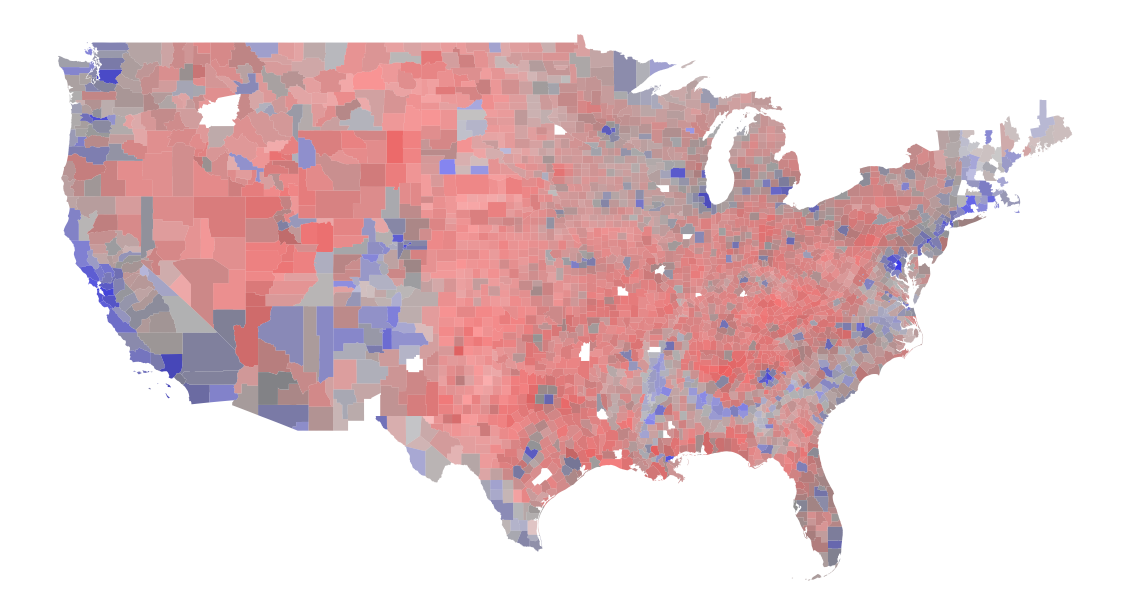

In [36]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.axis('off')
ax.set_aspect('equal')
# cm = mcol.LinearSegmentedColormap.from_list("BuRd",["r", 'w', "b"])
one_df.plot(color=one_df['rgb'], facecolor="none", ax=ax); # edgecolor="black", cmap=cm

In [102]:
shape_df

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID       NAME LSAD  \
0         39      071  01074048  0500000US39071  39071   Highland   06   
1         06      003  01675840  0500000US06003  06003     Alpine   06   
2         12      033  00295737  0500000US12033  12033   Escambia   06   
3         17      101  00424252  0500000US17101  17101   Lawrence   06   
4         28      153  00695797  0500000US28153  28153      Wayne   06   
...      ...      ...       ...             ...    ...        ...  ...   
3228      42      055  01213670  0500000US42055  42055   Franklin   06   
3229      12      001  00308548  0500000US12001  12001    Alachua   06   
3230      48      247  01383909  0500000US48247  48247   Jim Hogg   06   
3231      29      099  00758504  0500000US29099  29099  Jefferson   06   
3232      13      307  00352287  0500000US13307  13307    Webster   06   

           ALAND     AWATER                                           geometry  
0     1432479992   12194983  POLYGON ((-83.86976 39.05553, -83.86568 39.247...  
1     1912292630   12557304  POLYGON ((-120.07248 38.50987, -120.07239 38.7...  
2     1701544502  563927612  POLYGON ((-87.62999 30.87766, -87.62946 30.880...  
3      963936864    5077783  POLYGON ((-87.91028 38.57493, -87.90811 38.850...  
4     2099745573    7255476  POLYGON ((-88.94317 31.78421, -88.94335 31.824...  
...          ...        ...                                                ...  
3228  2000048804    1547614  POLYGON ((-78.09897 39.72247, -78.06930 39.748...  
3229  2266324954  242877007  POLYGON ((-82.65855 29.83014, -82.65149 29.825...  
3230  2942674729      92565  POLYGON ((-98.95467 27.26940, -98.79809 27.268...  
3231  1700345322   20143587  POLYGON ((-90.76280 38.29555, -90.75560 38.330...  
3232   542230980    2348162  POLYGON ((-84.65501 31.96153, -84.64536 31.961...  

[3233 rows x 10 columns]